# Table of Contents

1. [Header](#header)
2. [Particles](#particles)
3. [FFT Data](#fft)
4. [Halo and Subhalo](#halo)<br>
    4.1. [FOF Data](#fof)<br>
    4.2. [SUBFIND Catalog](#subcat)

### This notebook gives examples of how to use read_indra.py to read in Indra data on the SciServer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import read_indra as indra

**TO DO**: update below descriptions, and add some examples that demonstrate the two ways of specifying the runid (e.g., loop through and plot a bunch of FFT power spectra at one redshift)

Initialize the X, Y, and Z that specify the Indra run and the snapshot of the particle data (`snapnum`) and FFT data (`tnum`) for redshift 0. The data directory defaults to the location of run X_Y_Z on the FileDB (default) or the datascope (if `datascope = True`). Note that when `datadir` is specified, it determines which simulation is read, and X, Y, and Z are ignored.

In [2]:
runid = (2, 0, 0); snapnum = 63; tnum = 504

In [9]:
indra.get_loc(runid)

'/home/idies/workspace/indra_filedb/data02_03/2_0_0/'

In [ ]:
indra.get_loc(128)

In [ ]:
run = indra.Run(128)

In [ ]:
print(run.num,run.X,run.Y,run.Z)

In [ ]:
run = indra.Run((X,Y,Z))

In [ ]:
print(run.num,run.X,run.Y,run.Z)

# Header
<a id="header"></a>

Length data are in units of Mpc/h, velocities in km/s, and masses in MSun/h. Set `verbose = True` to print the `datadir`.

In [3]:
header = indra.getheader((X,Y,Z),snapnum,verbose=True)
print(header.keys())

Reading from /home/idies/workspace/indra_filedb/data02_03/2_0_0/
dict_keys(['np_file', 'mass', 'time', 'redshift', 'flag_sfr', 'flag_feedback', 'npart', 'flag_cooling', 'num_files', 'BoxSize', 'omega0', 'omegaL', 'hubble', 'flag_stellarage', 'flag_metals', 'hashtabsize'])


In [4]:
print(header['num_files'],header['npart'],header['mass'],header['time'],header['BoxSize'])

256 1073741824 70308895111.08398 0.9999999999999998 1000.0


# Particles
<a id="particles"></a>

Read positions only, no sorting:

In [6]:
pos_ns = indra.getpos((X,Y,Z),snapnum)
print(pos_ns[0])

[0.21537165 2.7080586  0.31402177]


Get velocities too, and sort particles and velocities by their IDs:

In [7]:
pos,vel,ids = indra.getparticles((X,Y,Z),snapnum,sort=True)

In [10]:
print(pos[0],vel[0],np.max(ids))

[990.69543 998.1114  999.1573 ] [-420.89322   -20.328901  -82.65336 ] 1073741823


# FFT Data
<a id="fft"></a>

Compute the k vectors. These arrays have the same shape as the FFT data.

In [11]:
kx,ky,kz = indra.getkvals()
k = np.sqrt(kx*kx+ky*ky+kz*kz)

Before reading, define some functions to calculate the power spectrum of this gridded FFT data.

In [12]:
def powspec(fft_re,fft_im,nbins=100,k=k):
    # PS = fft_re^2+fft_im^2
    # Requires k's already defined from kx,ky,kz = indra.getkvals()
    ps = fft_re*fft_re+fft_im*fft_im
    ps = ps[k>0] # ignore k = 0
    k = k[k>0]
    
    # average PS in logarithmic bins of k
    ps1d, kbin = np.histogram(np.log10(k),nbins,weights=ps)
    counts = np.histogram(np.log10(k),nbins)[0]
    ps1d = ps1d[counts>0]/counts[counts>0]
    
    binvals = kbin[0:nbins]+np.diff(kbin)//2
    binvals = binvals[counts>0]

    return binvals,ps1d

In [13]:
# the cosmology is hard-coded here but om = header['omega0']
def growthfunc(a, om=0.272):
    ol = 1-om
#    a = 1./(1.+z)
    da=a/10000.
    integral = 0.
    for i in range(10000):
        aa=(i+1)*da
        integral+=da/((aa*np.sqrt(om/(aa**3)+ol))**3)

    return 5*om/2*np.sqrt(om/a**3+ol)*integral

Read the CAMB linear power spectrum, which is normalized to z=0. (So to compare to Plin, multiply PS(z) by D(z)^2/D(z=0)^2.)

In [15]:
kth,pth = np.loadtxt('../pk_indra7313_CAMB.txt',unpack=True)

Now plot the ratio of power spectra from the FFT data to the linear theory PS at different redshifts.

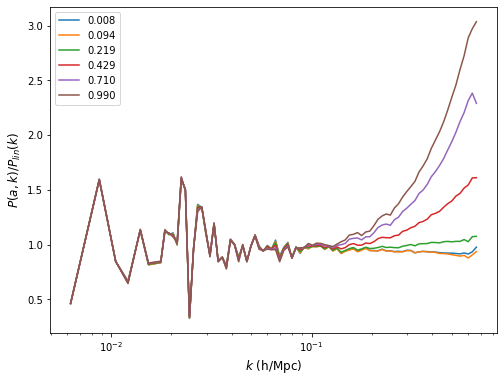

In [16]:
fft_re,fft_im,a = indra.getfft(runid,tnum)
bins,ps = powspec(fft_re,fft_im) # need bins to interpolate linear PS
plin = np.interp(10**bins,kth,pth)
norm = header['BoxSize']**3/header['npart']**2
plt.figure(figsize=(8,6))
for i in np.arange(0,501,100):
    fft_re,fft_im,a = indra.getfft(runid,i)
    bins,ps = powspec(fft_re,fft_im)
    normL = growthfunc(a)**2/growthfunc(1)**2
    plt.plot(10**bins,(ps*norm)/(plin*normL),label="{:.3f}".format(a)) 
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r'$k$ (h/Mpc)',size='large')
plt.ylabel(r'$P(a,k)/P_{lin}(k)$',size='large');

# Halo and Subhalo
<a id="halo"></a>

The FOF (or 'group') and SUBFIND headers contain the total number of groups/subhalos, and the number of files (NTask, which is always 256 for Indra).

In [3]:
TotNgroups, NTask = indra.getfofheader(runid,snapnum)
print(TotNgroups,NTask)
TotNsubs,NTask = indra.getsubheader(runid,snapnum)
print(TotNsubs,NTask)

3037186 256
3107008 256


In [21]:
# don't need to read all NTask headers to get value of NTask...
# WAIT nevermind, getfofheader isn't reading all 256 files... however, getsubheader does have to read all files
# in order to get the total number of subhalos... stupid
NTSub = np.empty(448)
for i in range(448):
    datadir = indra.get_loc(i)
    tabfile = '{0}/postproc_{1:03d}/sub_tab_{1:03d}.'.format(datadir,1)
    f = open(tabfile+str(0),'rb')
    Ngroups, Nids, TotNgroups, NTask, NSubs = np.fromfile(f, np.int32, 5)
    f.close()
    NTSub[i] = NTask

ValueError: not enough values to unpack (expected 5, got 0)

In [22]:
tabfile

'/home/idies/workspace/indra_filedb/data12_02/3_0_1//postproc_001/sub_tab_001.'

## FOF Data
<a id="fof"></a>

If all you want is the number of particles in each FOF halo (to multiply by `header['mass']`, for example), this is given by `groupLen`. `groupOffset` then gives the information needed to index `groupids`, the particle IDs in each group.

In [18]:
groupLen,groupOffset = indra.getfof(runid,snapnum)
print(np.min(groupLen),np.max(groupLen))

20 45443


In [19]:
groupLen,groupOffset,groupids = indra.getfofids(runid,snapnum)

The IDs of the particles in halo i are given by:

In [20]:
i = 0
haloIDs = groupids[groupOffset[i]:groupOffset[i]+groupLen[i]]

Let's plot some particles! I know that halo 0 (in snapshot 63 of 2_0_0) doesn't cross any boundaries, so we can ignore periodic boundary conditions for now. This will only work if you called `getparticles` with `sort=True`.

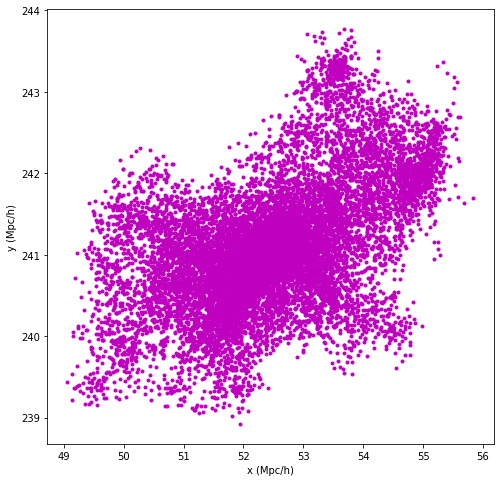

In [21]:
plt.figure(figsize=(8,8))
plt.plot(pos[haloIDs,0],pos[haloIDs,1],'m.')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)');

## Subhalo Catalog
<a id="subcat"></a>

There isn't much to the FOF data, since the unbinding procedure and calculation of halo properties is done by SUBFIND.

In [22]:
cat = indra.getsubcat(runid,snapnum)
subids = indra.getsubids(runid,snapnum)

In [23]:
print(cat.keys())

dict_keys(['NsubPerHalo', 'FirstSubOfHalo', 'subLen', 'subOffset', 'subParentHalo', 'M200mean', 'R200mean', 'M200crit', 'R200crit', 'M200tophat', 'R200tophat', 'SubPos', 'SubVel', 'SubVelDisp', 'SubVmax', 'SubSpin', 'SubMostBoundID', 'SubHalfMass'])


In [24]:
print(np.mean(cat['M200crit']),np.mean(cat['R200crit']),np.mean(np.abs(cat['SubVel'])))

4790549000000.0 0.20294867 239.85295


Indexing can get a bit tricky, so here are some examples. First let's pick a FOF group with 5 subhalos.

In [25]:
hasSubs = np.where(cat['NsubPerHalo'] == 5)[0]
thishalo = np.max(hasSubs)
print(thishalo,cat['M200crit'][thishalo],cat['R200crit'][thishalo])

3025907 30935913000000.0 0.51004255


The IDs of the particles in this FOF halo (before unbinding) can be found via:

In [26]:
haloIDs = groupids[groupOffset[thishalo]:groupOffset[thishalo]+groupLen[thishalo]]

Let's get the indexes of the subhalos with this parent halo. We can do this in two ways.

In [27]:
print(np.where(cat['subParentHalo'] == thishalo)[0])
subindices = cat['FirstSubOfHalo'][thishalo]+np.arange(cat['NsubPerHalo'][thishalo])
print(subindices)

[3095772 3095773 3095774 3095775 3095776]
[3095772 3095773 3095774 3095775 3095776]


The halo positions are calculated for every subhalo, so let's define the center as that of the main subhalo, and take care of periodic boundary conditions. (Eventualy I will write some PBC utility functions...)

In [28]:
boxsize = header['BoxSize']
center = cat['SubPos'][cat['FirstSubOfHalo'][thishalo],:]
print(center)
halopos = pos[haloIDs,:] - center
halopos[halopos < boxsize/2.] += boxsize
halopos[halopos > boxsize/2.] -= boxsize
print(np.mean(halopos,axis=0))

[ 98.51641 108.53143 964.5856 ]
[ 0.21417981 -0.37862423  0.41528755]


Now let's plot the particles in these halos! We'll plot the main halo in black first, so any particles that remain black were unbound by SUBFIND and don't belong to any subhalos (including the main `FirstSubOfHalo`).

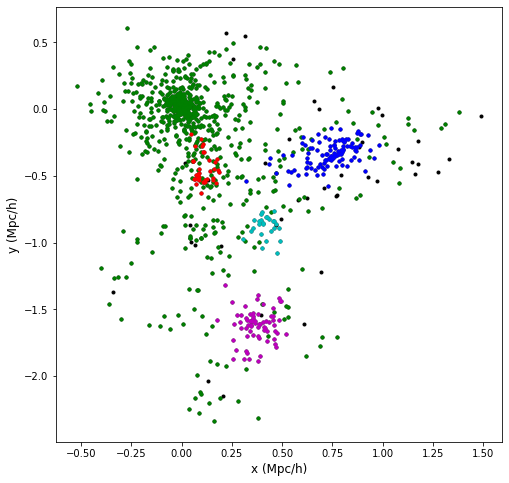

In [29]:
plt.figure(figsize=(8,8))
plt.scatter(halopos[:,0],halopos[:,1],marker = '.',color='k')
subindices = cat['FirstSubOfHalo'][thishalo]+np.arange(cat['NsubPerHalo'][thishalo])
colors = ['g','b','m','r','c']
for c, i in zip(colors,subindices):
    subIDs = subids[cat['subOffset'][i]:cat['subOffset'][i]+cat['subLen'][i]]
    subpos = pos[subIDs,:] - center
    subpos[subpos < boxsize/2.] += boxsize
    subpos[subpos > boxsize/2.] -= boxsize
    plt.scatter(subpos[:,0],subpos[:,1],marker ='.',color=c)
plt.xlabel('x (Mpc/h)',size='large')
plt.ylabel('y (Mpc/h)',size='large');